In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

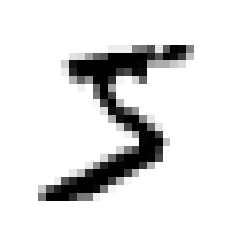

In [8]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

Convert labels to number

In [10]:
y = y.astype(np.uint8)

Create training and testing set

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier (5 or not 5)

In [12]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Test it out

In [15]:
sgd_clf.predict([some_digit])

array([ True])

# Evaluating Performance

Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself.
The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and it prints the same result:

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [17]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

c:\users\mmoustafa\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Looks great! But is it really?

Let's try a dumb classifier that just classifies every single image in the “not-5” class

In [20]:
from sklearn.base import BaseEstimator

In [21]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
never_5_clf = Never5Classifier()

In [23]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [24]:
from sklearn.model_selection import cross_val_predict

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix

In [28]:
#Each row in a confusion matrix represents an actual class, while each column represents a predicted class.
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

use precision and recall

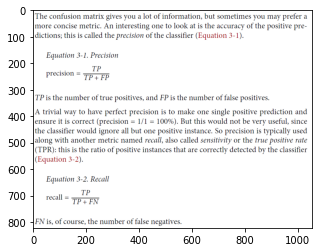

In [45]:
plt.imshow(plt.imread("./assets/prec_rec.png"))

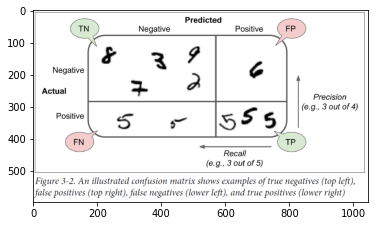

In [46]:
plt.imshow(plt.imread("./assets/conf_mat.png"))

In [32]:
from sklearn.metrics import precision_score, recall_score

In [33]:
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [34]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [35]:
from sklearn.metrics import f1_score

In [36]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [37]:
y_scores = sgd_clf.decision_function([some_digit])

In [38]:
y_scores

array([2164.22030239])

In [39]:
threshold = 0

In [40]:
y_some_digit_pred = (y_scores > threshold)

In [41]:
y_some_digit_pred

array([ True])

In [42]:
threshold = 8000

In [43]:
y_some_digit_pred = (y_scores > threshold)

In [44]:
y_some_digit_pred

array([False])

How to decide on what threshold to use?

In [47]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [48]:
from sklearn.metrics import precision_recall_curve

In [49]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Thresholds")
    plt.legend()

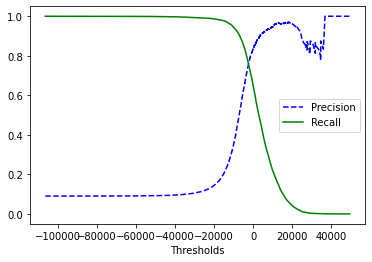

In [57]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [54]:
def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.plot(recalls[:-1], precisions[:-1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")

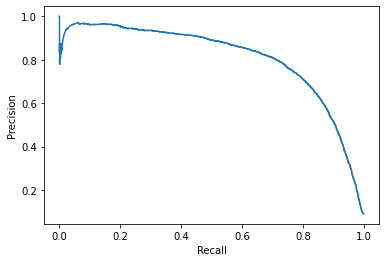

In [55]:
plot_precision_vs_recall(precisions, recalls, thresholds)
plt.show()

In [58]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [59]:
threshold_90_precision

3370.0194991439557

In [60]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [61]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [62]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [63]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [64]:
# page 97